# Netwulf

In [51]:
import requests
import netwulf as wulf
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import Counter

In [ ]:
# См. https://netwulf.readthedocs.io/en/latest/python_api/start.html
# https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model
G = nx.barabasi_albert_graph(n=100, m=3)
visualize(G)

In [2]:
def retrieve_all_plays(corpusname):
    response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/metadata')
    response.raise_for_status()
    return [play['playName'] for play in response.json()]

In [54]:
def netwulf_representation(corpusname, playname, size='weightedDegree', group=None, show_node_labels=True, show_link_labels=False, is_test=False, extension='png', labels='names'):
    """
    corpusname: 'ger'/'greek'/'rom'/'rus'/'shake'/'span'
    playname: 'pushkin-boris-godunov'/'lessing-emilia-galotti'/...
    size (what should we consider as the size of a node?):
    - 'numOfSpeechActs',
    - 'numOfWords' (the number of uttered words by a character),
    - 'degree' (the number of people/groups of people with whom a character appeared during the same minimal scene),
    - 'weightedDegree' (default),
    - 'numOfScenes' (the number of scenes in which a character appeared)
    group (what should we consider as group divider?):
    - 'gender' (MALE/FEMALE/UNKNOWN)
    - 'isGroup' (a group or a person)
    - None (default)
    show_node_labels (display characters' names or not): True/False (default: True)
    show_link_labels (display the weight of a link on itself): True/False (default: False)
    is_test (if `True`, the interactive environment will post its visualization to Python automatically after 5 seconds): True/False (default: False)
    extension (extension of output file): 'png'/'jpg'/'pdf'/...
    labels (whether use xml:ids or names of characters as node labels): 'ids'/'names'
    """

    # check that 'labels' field is either 'ids' or 'names'
    assert(labels in ['ids', 'names'])

    # define titles for output files
    title = corpusname + '_' + playname
    json_title = '_'.join([corpusname, playname, size, str(group), labels])

    # define config for visualization
    config = {
        # Input/output
        'zoom': 3,
        # Nodes
        'node_fill_color': '#1cf2c7',
        'display_node_labels': True,
        'node_size': 4,
        'node_stroke_width': 0.1,
        # Links
        'link_color': '#ff7500',
        'link_width': 0.7,
        'link_width_variation': 1,
    }
    
    try:
        # if there is a corresponding json file

        network, config, _ = wulf.load(f"{json_title}.json")
        # use nodes and links from the network
        nodes = network['nodes']
        links = network['links']
        # replace 'radius' by 'size' as visualize method doesn't take into consideration 'radius' field
        for node in network['nodes']:
            node['size'] = node['radius']
        network, config = wulf.visualize(network, config=config, is_test=is_test, verbose=False, plot_in_cell_below=False)
    except FileNotFoundError:
        # if there is no corresponding json file

        # make a request for nodes
        nodes_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/cast')
        nodes_response.raise_for_status()

        # define names (either 'ids' or 'names')
        if labels == 'names':
            names = {character['id']:character['name'] for character in nodes_response.json()}
            if len(names) > len(set(names.values())):
                duplicates = {item: 1 for item, count in Counter(names.values()).items() if count > 1}
                for key, value in sorted(names.items()):
                    if value in duplicates:
                        names[key] = value + '_' + str(duplicates[value])
                        duplicates[value] += 1
        else:
            names = {character['id']:character['id'] for character in nodes_response.json()}

        # list of dicts with node's labels and sizes
        nodes = [{'id': names[character['id']], 'size': character[size]} for character in nodes_response.json()]
        # add 'group' attribute to the nodes if group is not None
        if group is not None:
            nodes = [dict(node, **{'group': character[group]}) for node, character in zip(nodes, nodes_response.json())]
        # make a request for links
        links_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/networkdata/csv')
        links_response.raise_for_status()
        # list of dicts with link's sources, targets and weights
        links = []
        for link in links_response.text.split('\n')[1:]:  # skip header
            source, _, target, weight = link.split(',')
            links.append({'source': names[source], 'target': names[target], 'weight': int(float(weight))})
        # visualize a network and save the appropriate settings
        network, config = wulf.visualize({'nodes': nodes, 'links': links}, config=config, is_test=is_test, verbose=False, plot_in_cell_below=False)

    fig, ax = wulf.draw_netwulf(network, figsize=24)
    # add node labels if necessary
    if show_node_labels:
        for node in nodes:
            wulf.add_node_label(ax, network, node['id'], label=node['id'], size=20)
    # add link labels if necessary
    if show_link_labels:
        for link in links:
            wulf.add_edge_label(ax, network, (link['source'], link['target']), link['weight'], size=20)
    # add title
    ax.set_title(title, size=24)
    plt.subplots_adjust(top=0.88)
    # save picture
    plt.savefig(f'{title}.{extension}', bbox_inches='tight')
    # and display here
    plt.show()
    # save network and config to json file
    wulf.save(f'{json_title}.json', network, config)

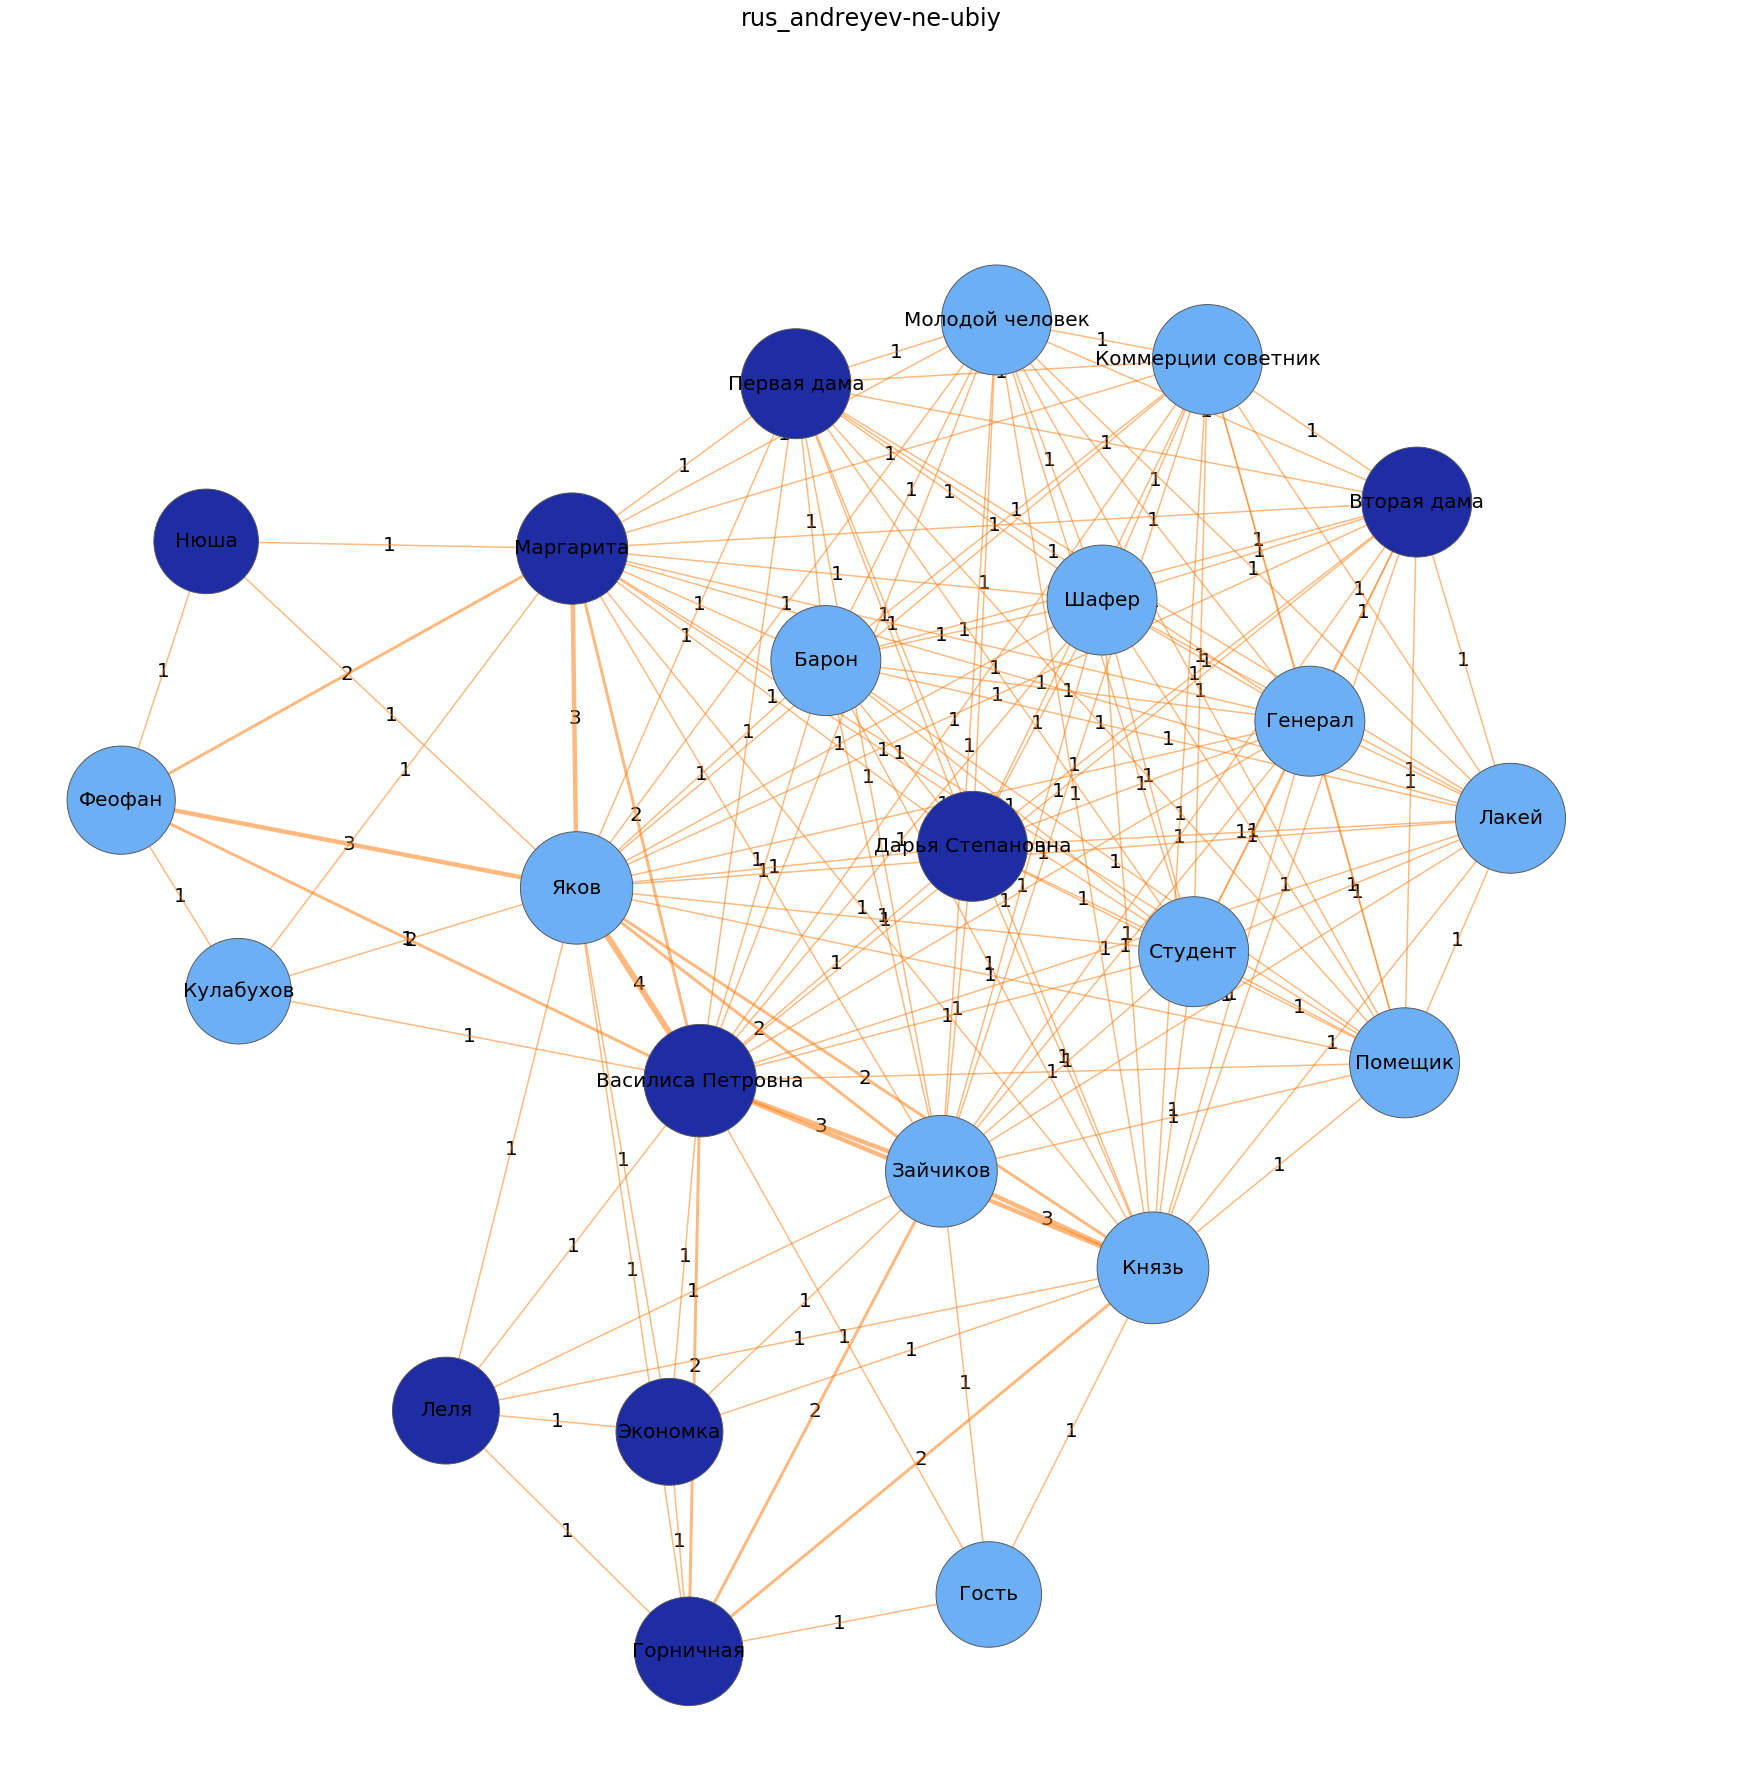

In [41]:
netwulf_representation('rus', 'andreyev-ne-ubiy', group='gender', show_link_labels=True)

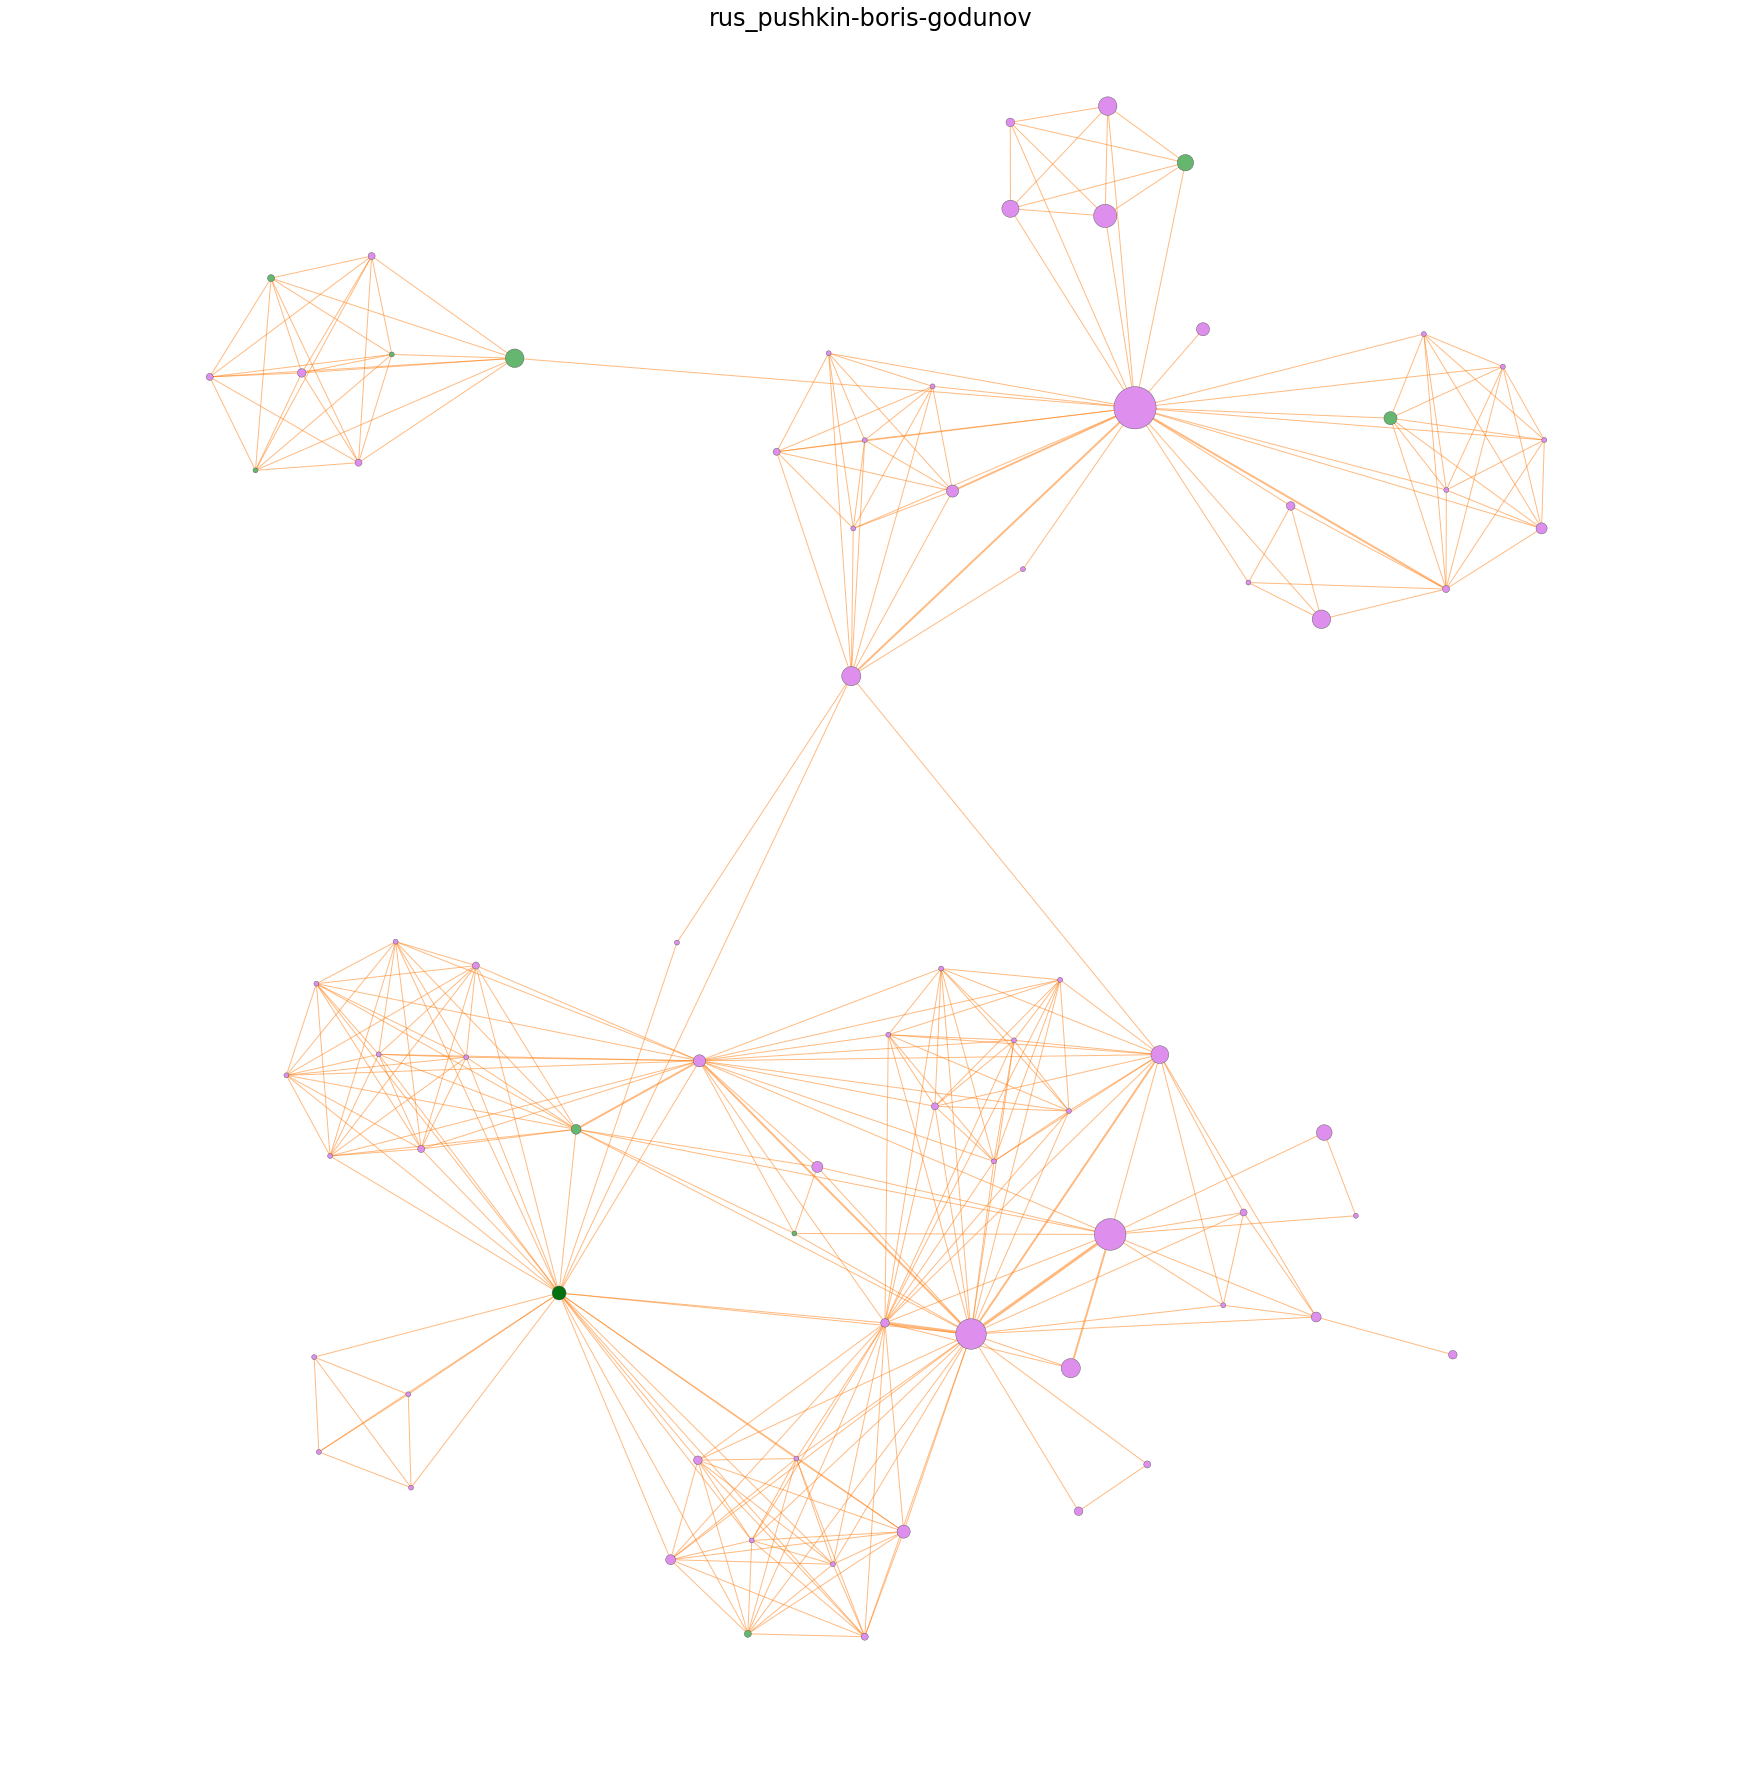

In [55]:
netwulf_representation('rus', 'pushkin-boris-godunov', group='gender', size='numOfSpeechActs', show_node_labels=False)

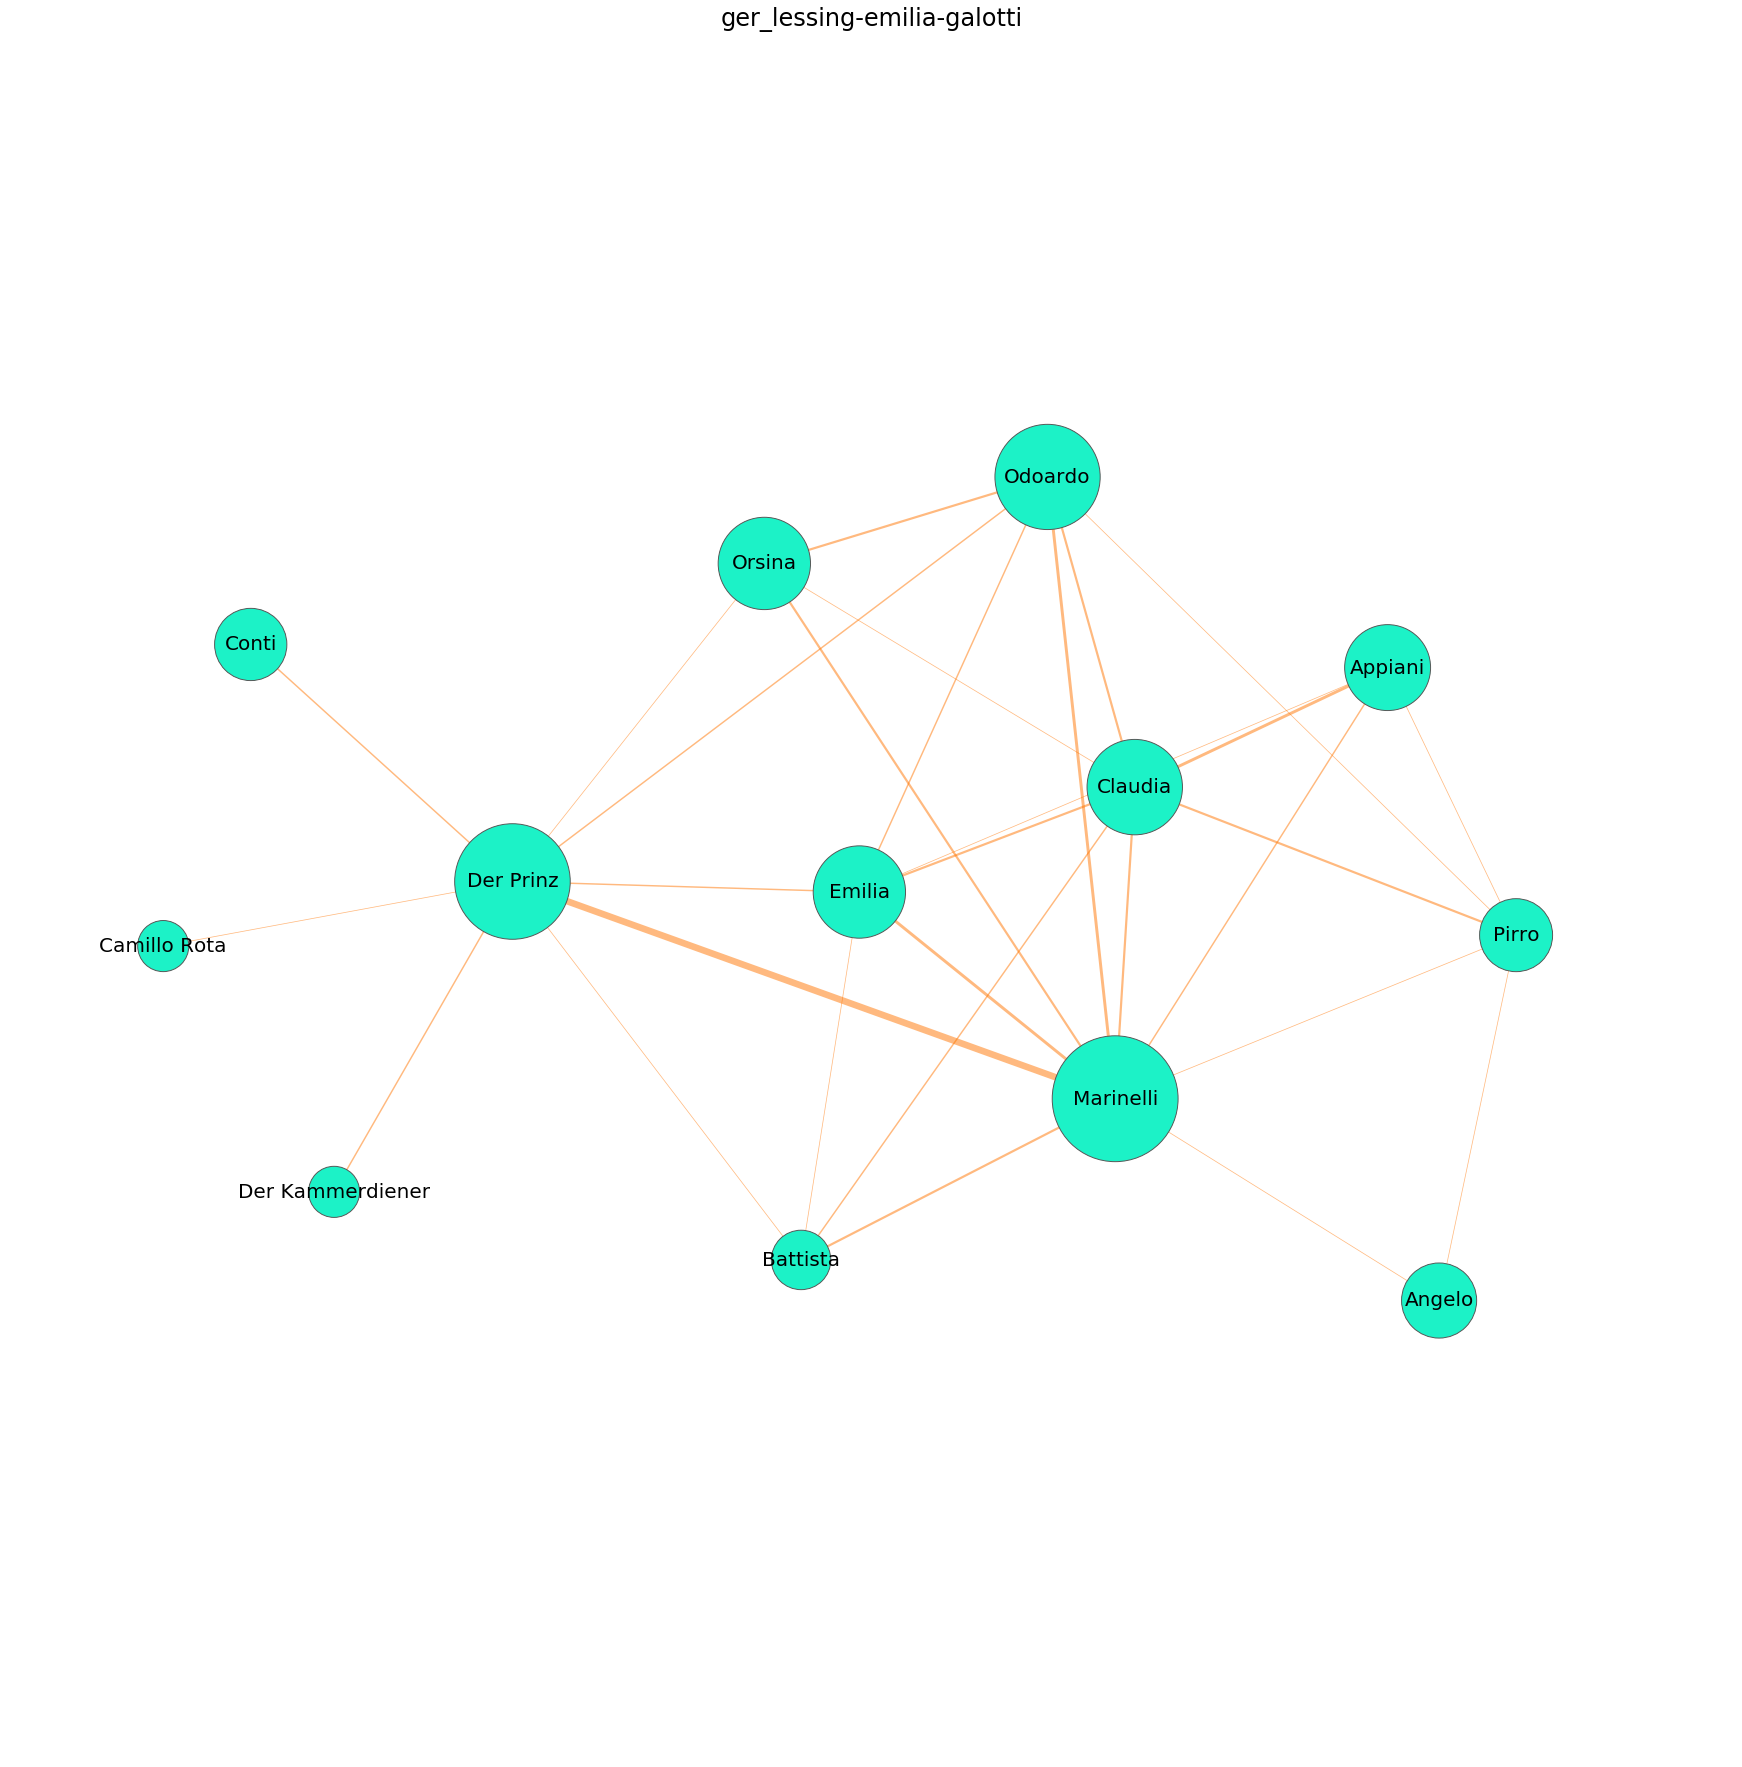

In [264]:
netwulf_representation('ger', 'lessing-emilia-galotti', size='numOfSpeechActs')

In [141]:
playnames = retrieve_all_plays('rus')

In [ ]:
for playname in playnames:
    netwulf_representation('rus', playname, size='weightedDegree', group='gender', show_link_labels=True, is_test=True)

# WebWeb

In [226]:
import webweb
from webweb import Web
import json

In [269]:
def webweb_representation(corpusname, playname, labels='names'):
    """
    script for one play

    corpusname: 'ger'/'greek'/'rom'/'rus'/'shake'/'span'
    playname: 'pushkin-boris-godunov'/'lessing-emilia-galotti'/...
    labels (whether use xml:ids or names of characters as node labels): 'ids'/'names'
    """

    # define titles for output files
    title = corpusname + '_' + playname

    # make a request for nodes
    nodes_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/cast')
    nodes_response.raise_for_status()

    # define names (either 'ids' or 'names')
    if labels == 'names':
        names = {character['id']:character['name'] for character in nodes_response.json()}
        if len(names) > len(set(names.values())):
            duplicates = {item: 1 for item, count in Counter(names.values()).items() if count > 1}
            for key, value in sorted(names.items()):
                if value in duplicates:
                    names[key] = value + '_' + str(duplicates[value])
                    duplicates[value] += 1
    else:
        names = {character['id']:character['id'] for character in nodes_response.json()}

    display = {}
    display['nodes'] = {}

    for node in nodes_response.json():
        name = names[node['id']]
        # remove 'id' and 'name' fields
        del node['id']
        del node['name']
        # add as attribute to the 'nodes' field
        display['nodes'][name] = node

    # make a request for links
    links_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/networkdata/csv')
    links_response.raise_for_status()

    adjacency = []
    for link in links_response.text.split('\n')[1:]:  # skip header
        source, _, target, weight = link.split(',')
        adjacency.append([names[source], names[target], int(float(weight))])

    # display settings
    display.update(
        {
            'attachWebwebToElementWithId': None,
            'charge': 500,
            'colorBy': 'gender',
            'colorPalette': 'Set1',
            'height': 500,  # 1200
            'linkLength': 150,
            'linkStrength': 0.75,
            'radius': 7,
            'scaleLinkWidth': True,
            'showNodeNames': True,
            'sizeBy': 'weightedDegree',
            'width': 500,  # 1200
        }
    )

    web = Web(adjacency=adjacency, title=title, display=display)
    web.save(title + '.html')
    web.show()

In [263]:
webweb_representation('rus', 'pushkin-boris-godunov')

In [270]:
webweb_representation('ger', 'lessing-emilia-galotti')

In [256]:
def webweb_representation_of_several_plays(corpusname=None, specific_playnames={}, labels='names'):
    """
    script for several plays

    corpusname: 'ger'/'greek'/'rom'/'rus'/'shake'/'span'
    specific_playnames (if you want to display only specific plays): {'rus': ['pushkin-boris-godunov', ...], 'ger': ['lessing-emilia-galotti', ...], ...}
    labels (whether use xml:ids or names of characters as node labels): 'ids'/'names'
    """

    # get playnames
    if specific_playnames:
        corpus_playnames = [(corpusname, name) for corpusname, names in specific_playnames.items() for name in names]
        title = '_'.join([name for corpusname, name in corpus_playnames])
    else:
        assert(corpusname is not None)
        # retrieve all playnames of a corpus
        corpus_playnames = [(corpusname, playname) for playname in retrieve_all_plays(corpusname)]
        title = corpusname

    # display settings
    display = {
        'attachWebwebToElementWithId': None,
        'charge': 500,
        'colorBy': 'gender',
        'colorPalette': 'Set1',
        'height': 500,  # 1200
        'linkLength': 150,
        'linkStrength': 0.75,
        'radius': 7,
        'scaleLinkWidth': True,
        'showNodeNames': True,
        'sizeBy': 'weightedDegree',
        'width': 500,  # 1200
    }

    web = Web(display=display, title=title)

    for corpusname, playname in corpus_playnames:
        # make a request for nodes
        nodes_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/cast')
        nodes_response.raise_for_status()

        # define names (either 'ids' or 'names')
        if labels == 'names':
            names = {character['id']:character['name'] for character in nodes_response.json()}
            if len(names) > len(set(names.values())):
                duplicates = {item: 1 for item, count in Counter(names.values()).items() if count > 1}
                for key, value in sorted(names.items()):
                    if value in duplicates:
                        names[key] = value + '_' + str(duplicates[value])
                        duplicates[value] += 1
        else:
            names = {character['id']:character['id'] for character in nodes_response.json()}

        display = {}
        nodes = {}

        for node in nodes_response.json():
            name = names[node['id']]
            # remove 'id' and 'name' fields
            del node['id']
            del node['name']
            # add as attribute to the nodes
            nodes[name] = node

        # make a request for links
        links_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/networkdata/csv')
        links_response.raise_for_status()

        adjacency = []
        for link in links_response.text.split('\n')[1:]:  # skip header
            source, _, target, weight = link.split(',')
            adjacency.append([names[source], names[target], int(float(weight))])

        # create network 'playname'
        web.networks.playname(adjacency=adjacency, nodes=nodes)
        
        # in order to save titles...
        vars(web.networks)[playname] = vars(web.networks)['playname']
        del vars(web.networks)['playname']

    web.save(title + '.html')
    web.show()

In [257]:
webweb_representation_of_several_plays(specific_playnames={'rus': ['pushkin-boris-godunov', 'andreyev-ne-ubiy']})

In [259]:
webweb_representation_of_several_plays(specific_playnames={'rus': ['pushkin-boris-godunov'], 'ger': ['lessing-emilia-galotti']})

In [260]:
webweb_representation_of_several_plays(corpusname='rus')

In [261]:
webweb_representation_of_several_plays(corpusname='ger')

In [ ]:
# multiple layers?
# but what to consider as a weight of an edge between nodes in a scene?

1) png picture has very bad quality